In [1]:
# import pandas as pd
# import numpy as np
import matplotlib.pyplot as plt
# import math
# from networkx import minimum_cut, DiGraph
from mip import *
# from itertools import product

from src.read_instance import MDOVRP
# rnd = np.random
# rnd.seed(454)

In [2]:
# filepath = "Instancias/ES-n78-m2-Q10138.txt"
filepath = "Instancias/Vrp-Set-A/A-n80-m2-Q60.vrp"

In [3]:
N, D, V, Q, q, c, coord_x, coord_y = MDOVRP(filepath)

In [4]:
# fazendo c ser simétrica
# c = {(i,j) : (c[i,j] + c[j, i])/2  for (i,j) in c}

Usando a formulação $MDOVRP_{2i− flv}$ de Lalla-Ruiz e Mes (2019)


    Lalla-Ruiz, Eduardo, and Martijn Mes. "Mathematical formulations and improvements for the multi-depot open vehicle routing problem." Optimization Letters 15 (2021): 271-286.

In [5]:
#cria o modelo
model = Model('PRVMD', solver_name = GUROBI)

# Variaveis de decisao
x = [[model.add_var(var_type=BINARY) if i!=j else model.add_var(lb=0, ub=0) for i in V] for j in V]
u = [[model.add_var(var_type=CONTINUOUS) if i!=j else model.add_var(lb=0, ub=0) for i in V] for j in V]
y = [model.add_var(var_type=BINARY) for i in N]

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID
Academic license - for non-commercial use only - registered to thiago.giachetto@aluno.ufop.edu.br


\begin{equation}
\label{eq:9}
    x_{ij} \in \{0, 1\}, \quad \forall i, j \in V
\end{equation}

\begin{equation}
\label{eq:10}
    u_{ij} \geq 0, \quad \forall i, j \in V
\end{equation}

In [6]:
# Funcao objetivo
model.objective = minimize(xsum(x[i][j] * c[i,j] for i in V for j in V if i != j))

\begin{equation}
\label{eq:1}
 Minimizar \quad \sum_{i \in V }\sum_{j \in V} c_{ij}x_{ij}
\end{equation}

In [7]:
# Restricao 2
for j in N:
#     model += xsum(x[i][j] for i in V if i != j and c[i][j] <= 180) == 1
    model += xsum(x[i][j] for i in V if i != j) == 1

\begin{equation}
    \sum_{i \in V, i \neq j}x_{ij} = 1, \quad \forall j \in N
    \tag{2}
\end{equation}

In [8]:
# Restricao 18

for j in N:
    model += (xsum(x[i][j] for i in V if i != j) - xsum(x[j][i] for i in N if i != j)) >= 0

\begin{equation}
    \sum_{i \in V, i \neq j}x_{ij} - \sum_{i \in N, i \neq j}x_{ji} \geq 0, \quad \forall j \in N
    \tag {18}
\end{equation}

In [9]:
# Restricao 19
for i in V:
    for j in V:
        if i != j:
            model += x[i][j] + x[j][i] <= 1

\begin{equation}
    x_{ij} + x_{ji} \leq 1, \quad \forall i, j \in V, i \neq j
    \tag {19}
\end{equation}

In [10]:
# Restricao 20
# Ninguem volta para o depósito
model += xsum(x[j][k] for k in D for j in V) == 0

\begin{equation}
    \sum_{k \in D}\sum_{j \in V}x_{jk} = 0
    \tag {20}
\end{equation}

In [11]:
# Restricao 21
for j in N:
    model += xsum(u[i][j] for i in V if i != j) - xsum(u[j][i] for i in V if i != j) >= q[j]

\begin{equation}
    \sum_{i \in V, i \neq j}u_{ij} - \sum_{i \in V, i \neq j}u_{ji} \geq q_j, \quad \forall j \in N
    \tag {21}
\end{equation}

In [12]:
#Restricao 22
for i in N:
    for j in N:
        model += (Q - q[i])*x[i][j] >= u[i][j]

\begin{equation}
    (Q - q_i) \cdot x_{ij} \geq u_{ij}, \quad \forall i, j \in N
    \tag {22}
\end{equation}

In [13]:
# Restricao 23
for k in D:
    for j in N:
        model += Q * x[k][j] >= u[k][j]

\begin{equation}
    Q \cdot x_{kj} \geq u_{kj}, \quad \forall k \in D, j \in N
    \tag {23}
\end{equation}

In [14]:
# Restricao 8
d = [min([c[j, i] for j in D]) for i in N]
r = [min([c[j, i] for j in N if i != j]) for i in N]
M = max(r)

for i in N:
    model += d[i] + M * y[i] >= r[i]

\begin{equation}
    d_{i} + M y_{i} \geq r_{i}, \quad \forall k \in N
    \tag {8}
\end{equation}

In [15]:
# Restricao 9

for i in N:
    k_l = D[np.argmin([c[j, i] for j in D], axis=0)]
    model += x[k_l][i] >= y[i]

\begin{equation}
    x_{k'i} \geq y_{i}, \quad \forall i \in N, k' = argmin(c_{ki})_{k \in D}
    \tag {9}
\end{equation}

In [16]:
# Restricao 10

model += xsum(x[k][i] for i in N for k in D) >= np.ceil(sum(q)/Q)

\begin{equation}
    \sum_{i \in N}\sum_{k \in D}x_{ki} \geq \lceil \frac{\sum_{i \in N} q_{i}}{Q} \rceil
    \tag {10}
\end{equation}

In [17]:
# Restricao de distancia maxima entre duas cidades

for i in V:
    for j in V:
        if i != j:
            model += c[i,j]*x[i][j] <= 180

In [18]:
# Resolve o modelo        
# model.optimize(max_seconds=7200)
model.optimize(max_seconds=30)
print("status: {} objective value : {} best possible: {}".format(model.status, model.objective_value, model.objective_bound))


#                   Objective                Residual
# Iter       Primal          Dual         Primal    Dual     Compl     Time
# usando c simétrica
# 421367 260494 2594.76360   95  102 2608.15000 2560.04596  1.84%   117 7200s
# usando c original
# 351473 211907 2581.12423   69  161 2608.75395 2552.97499  2.14%   138 7200s

Set parameter TimeLimit to value 30
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Academic license - for non-commercial use only - registered to thiago.giachetto@aluno.ufop.edu.br
Optimize a model with 20246 rows, 13528 columns and 65850 nonzeros
Model fingerprint: 0xc772627a
Variable types: 6806 continuous, 6722 integer (6722 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [1e+01, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 5766.8171932
Presolve removed 10837 rows and 1224 columns
Presolve time: 0.27s
Presolved: 9409 rows, 12304 columns, 43024 nonzeros
Found heuristic solution: objective 3445.4188966
Variable types: 6112 continuous, 619

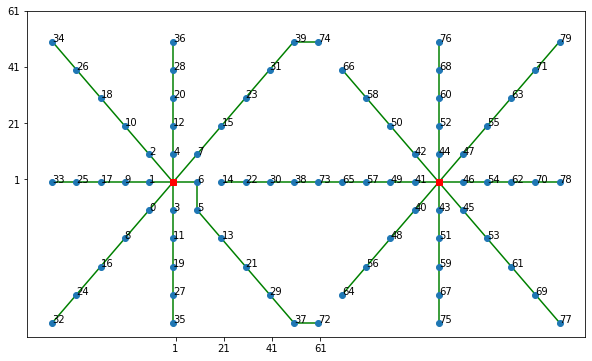

In [19]:
# --- PLOTA O GRAFICO ---
plt.figure(figsize=(10, 6))
plt.scatter(coord_x[0:], coord_y[0:])
for i in N:
    plt.annotate(f"{i}", (coord_x[i], coord_y[i]))
for i in D:
    plt.plot(coord_x[i], coord_y[i], c = 'r', marker = 's')

for i in V:
    for j in V:
        if x[i][j].x > 0:
            plt.plot([coord_x[i], coord_x[j]], [coord_y[i], coord_y[j]], c='g', zorder=0)
    
#escala dos eixos
plt.yticks([i for i in range(1,80,20)]); 
plt.xticks([i for i in range(1,80,20)]); 